<a href="https://colab.research.google.com/github/GamelinAl/mbtrack2_examples/blob/main/mbtrack2_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wellcome to the mbtrack2 demo !

The idea behind **mbtrack2** is to build a **coherent object-oriented framework** to work on **collective effects** in synchrotrons. mbtrack2 is composed of different modules allowing to easily write scripts for **single bunch** or **multi-bunch** tracking using MPI parallelization
in a transparent way. 

The base of the tracking model of mbtrack2 is inspired by **mbtrack**, a C multi-bunch tracking code initially developed at SOLEIL. In addition, many tools to prepare or analyse tracking simulations are included.

The aim of this notebook is to demonstrate the main features of **mbtrack2** related to **tracking**.

## Conventions

### Tracking
In **mbtrack2**, a particle is described as a point $(x,x',y,y',\tau,\delta)$ in the 6-dimensional phase-space: 
+ $x$ and $y$ are the horizontal and vertical position.
+ $x'=\frac{dx}{ds}$ and $y'=\frac{dy}{ds}$ are the horizontal and vertical transverse momenta. 
+ $\tau$ is the time difference with respect to the reference particle.
+ $\delta = \frac{E - E_0}{E_0}$ is the relative energy deviation from the reference energy $E_0$. 

A particle is late compared to the reference particle if $\tau > 0$.

### Units
mbtrack2 uses SI units.

### RF
mbtrack2 uses the cosine convention for RF voltage.

### Array structure
The arrays are strcutured as [horizontal_value, vertical_value, longitudinal_value].

# Installation

In [1]:
! git clone https://gitlab.synchrotron-soleil.fr/PA/collective-effects/mbtrack2.git

Cloning into 'mbtrack2'...
remote: Enumerating objects: 1139, done.
remote: Counting objects: 100% (231/231), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 1139 (delta 159), reused 213 (delta 148), pack-reused 908
Receiving objects: 100% (1139/1139), 353.44 KiB | 452.00 KiB/s, done.
Resolving deltas: 100% (756/756), done.


In [2]:
%cd mbtrack2

/content/mbtrack2


In [3]:
pip install -r requirements.txt

     |████████████████████████████████| 2.5 MB 4.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185312 sha256=19b71d4d34ae88e97f5afa2fc279ff8bd8fdf2aee10ee2038273290049d33896
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py


# Synchrotron object

In [4]:
import numpy as np
from mbtrack2.tracking import Synchrotron, Electron
from mbtrack2.utilities import Optics

To known how to use and define mbtrack2 classes, use the help:


```
help(Synchrotron)
```



Let us define some paramter for our synchrotron:

In [5]:
h = 20 # Harmonic number of the accelerator.
L = 100 # Ring circumference in [m].
E0 = 1.5e9 # Nominal (total) energy of the ring in [eV].
particle = Electron() # Particle considered.
ac = 1e-3 # Momentum compaction factor.
U0 = 200e3 # Energy loss per turn in [eV].
tau = np.array([1e-3, 1e-3, 2e-3]) # Horizontal, vertical and longitudinal damping times in [s].
tune = np.array([12.2, 15.3]) # Horizontal and vertical tunes.
emit = np.array([10e-9, 10e-12]) # Horizontal and vertical equilibrium emittance in [m.rad].
sigma_0 = 15e-12 # Natural bunch length in [s].
sigma_delta = 1e-3 # Equilibrium energy spread.
chro = [2.0, 3.0] # Horizontal and vertical (non-normalized) chromaticities.

The `Optics` class stores optic functions related values.

Here we define the values of the optic functions at the tracking location:

In [6]:
local_beta = np.array([3, 2]) # Beta function at the tracking location.
local_alpha = np.array([0, 0]) # Alpha function at the tracking location.
local_dispersion = np.array([0, 0, 0, 0]) # Dispersion function and its derivative at the tracking location.
optics = Optics(local_beta=local_beta, local_alpha=local_alpha, 
                  local_dispersion=local_dispersion)

The `Synchrotron` class stores most global lattice parameters:

In [7]:
ring = Synchrotron(h=h, optics=optics, particle=particle, L=L, E0=E0, ac=ac, 
                   U0=U0, tau=tau, emit=emit, tune=tune, 
                   sigma_delta=sigma_delta, sigma_0=sigma_0, chro=chro)

Now the `Synchrotron` object can be used:

In [8]:
ring.T0 # Revolution time in [s].

3.3356409519815204e-07

In [9]:
ring.f1 # Fundamental RF frequency in [Hz].

59958491.6

In [10]:
ring.gamma # Relativistic Lorentz gamma.

2935.42677536081

Most class attributes in mbtrack are dynamically linked when possible:

In [11]:
ring.T0 = 1e-6 # Revolution time in [s].
ring.L # Ring circumference in [m].

299.792458

An Accelerator Toolbox (AT) format lattice can also be loaded using:


```
optics = Optics(lattice_file=lattice_file)
ring = Synchrotron(h, optics, particle)
```
In that case, the AT lattice paramters are used to fill the `Synchrotron` object.


Main conventions used:
+ mbtrack2 uses SI units.
+ the arrays are strcutured as `[horizontal_value, vertical_value, longitudinal_value]`.

# Bunch and Beam objects

In [12]:
from mbtrack2.tracking import Bunch, Beam

## Bunch

Defines a `Bunch` object with 5 macro-particles and a current of 1 mA:

In [13]:
mybunch = Bunch(ring, mp_number=5, current=1e-3)
mybunch

     x   xp    y   yp  tau  delta
0  0.0  0.0  0.0  0.0  0.0    0.0
1  0.0  0.0  0.0  0.0  0.0    0.0
2  0.0  0.0  0.0  0.0  0.0    0.0
3  0.0  0.0  0.0  0.0  0.0    0.0
4  0.0  0.0  0.0  0.0  0.0    0.0

The coordinates for a single dimension can be accessed by brackets:

In [14]:
mybunch["x"]

array([0., 0., 0., 0., 0.])

In [15]:
mybunch["x"] += 1e-3 # add 1 mm offset in horizontal dimension
mybunch

       x   xp    y   yp  tau  delta
0  0.001  0.0  0.0  0.0  0.0    0.0
1  0.001  0.0  0.0  0.0  0.0    0.0
2  0.001  0.0  0.0  0.0  0.0    0.0
3  0.001  0.0  0.0  0.0  0.0    0.0
4  0.001  0.0  0.0  0.0  0.0    0.0

Initialize the bunch macro-particles to have gaussian distribution corresponding to the `Synchrotron` object equilibrium parameters:

In [16]:
mybunch.init_gaussian()
mybunch

          x        xp         y            yp           tau     delta
0  0.000167  0.000046 -0.000002  4.894223e-09  1.457217e-11  0.001107
1  0.000038  0.000056 -0.000002  4.666150e-08  1.420120e-11  0.000039
2 -0.000207  0.000101 -0.000004  3.270033e-07 -6.484481e-13 -0.000225
3  0.000021 -0.000059  0.000006  1.318513e-06  5.321753e-12  0.000392
4 -0.000121 -0.000001 -0.000003  9.332312e-07  8.391381e-12 -0.001752

Compute statistical quantities for each dimensions:

In [17]:
mybunch.mean # Mean position of alive particles for each coordinates.

array([-2.04253187e-05,  2.84766408e-05, -1.02548257e-06,  5.26060679e-07,
        8.36761243e-12, -8.74502667e-05])

In [18]:
mybunch.std # Standard deviation of the position of alive particles for each coordinates.

array([1.30383610e-04, 5.45947452e-05, 3.61563036e-06, 5.16687649e-07,
       5.71129630e-12, 9.44617132e-04])

In [19]:
mybunch.emit # Bunch emittance for each plane.

array([7.75559963e-09, 2.67753601e-12, 9.57351816e-15])

Change the bunch current:

In [20]:
mybunch.current # bunch current in [A]

0.001

In [21]:
mybunch.charge = 5e-9 # charge in [C]
mybunch.current

0.005

This boolean array shows which macro-particles are still "alive" and thoses which are lost:

In [22]:
mybunch.alive

array([ True,  True,  True,  True,  True])

In [23]:
mybunch.alive[2] = False
mybunch.alive

array([ True,  True, False,  True,  True])

Lost marco-particles are no longer taken in account for the tracking or to compute bunch parameters:

In [24]:
mybunch.current

0.004

In [25]:
mybunch

          x        xp         y            yp           tau     delta
0  0.000167  0.000046 -0.000002  4.894223e-09  1.457217e-11  0.001107
1  0.000038  0.000056 -0.000002  4.666150e-08  1.420120e-11  0.000039
2  0.000021 -0.000059  0.000006  1.318513e-06  5.321753e-12  0.000392
3 -0.000121 -0.000001 -0.000003  9.332312e-07  8.391381e-12 -0.001752

## Beam

The `Beam` class is defined like an array container for `Bunch` objects:

In [26]:
mybeam = Beam(ring) # define an empty beam
mybeam[0] # no bunch in the 1st RF bucket as the beam is empty

Empty DataFrame
Columns: [x, xp, y, yp, tau, delta]
Index: []

Define a filling pattern for our beam:

In [27]:
filling_pattern = np.zeros(ring.h) # empty array of size ring.h
filling_pattern[0:10] = 10e-3 # the first 10 bunches will be filled with 10 mA
filling_pattern[10:15] = 5e-3
filling_pattern[15:20] = 20e-3

Initialize our `Beam` object with a given filling pattern and 1000 macro-particles per bunch:

In [28]:
mybeam.init_beam(filling_pattern, mp_per_bunch=1e3)

It is possible to access the bunch located in the $n^{th}$ RF bucket using brackets:  

In [29]:
mybeam[5]

            x        xp             y            yp           tau     delta
0    0.000037  0.000013 -2.543095e-06 -3.101018e-06 -5.087891e-12 -0.000737
1    0.000151 -0.000016  1.353694e-06 -1.118413e-06  2.142205e-11 -0.002040
2    0.000243  0.000058 -9.433485e-06  2.594158e-06 -1.413505e-11 -0.001256
3    0.000073  0.000027 -5.027011e-06 -1.140515e-06  9.855368e-12  0.000943
4    0.000313 -0.000049 -3.378621e-06  5.712363e-07  6.575415e-12  0.000779
..        ...       ...           ...           ...           ...       ...
995  0.000141  0.000114 -7.730607e-07 -2.298574e-06 -2.496193e-11 -0.001145
996 -0.000186  0.000093 -1.313724e-06  1.201262e-07 -7.894270e-12  0.000171
997  0.000118  0.000121 -2.254755e-06 -2.044996e-06  2.706899e-11  0.001132
998  0.000321 -0.000103  3.128740e-06 -1.435538e-06 -2.266196e-11 -0.000669
999  0.000009 -0.000026  1.678159e-06 -9.540326e-08 -1.267561e-11 -0.001505

[1000 rows x 6 columns]

Beam and bunch parameters can be accessed:

In [30]:
mybeam.current # Total beam current in [A]

0.22499999999999998

In [31]:
mybeam.bunch_current # Current in each bunch in [A]

array([0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
       0.01 , 0.005, 0.005, 0.005, 0.005, 0.005, 0.02 , 0.02 , 0.02 ,
       0.02 , 0.02 ])

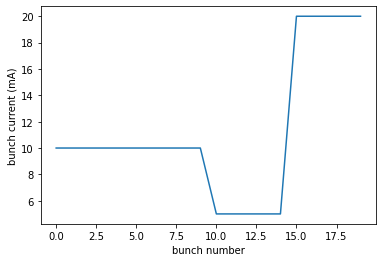

In [32]:
fig = mybeam.plot("bunch_current")

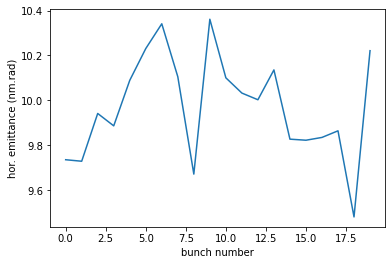

In [33]:
fig = mybeam.plot("bunch_emit","x")

# Tracking

In mbtrack2, tracking is done by calling the `track` method from different objects. This `track` method applies a transformation to the macro-particles coordinates.

In [34]:
from time import time
from mbtrack2.tracking import LongitudinalMap, RFCavity, SynchrotronRadiation, TransverseMap

For example, the `LongitudinalMap` element applies the following transform:
+ $\tau = \tau + \eta T_0 \delta $ 
+ $\delta = \delta - \frac{U_0}{E_0}$

Which corresponds to the transformation of the longitudinal coordinates ($\tau$, $\delta$) undergoes during a full turn in the synchrotron.

In [35]:
LongMap = LongitudinalMap(ring) # define the LongitudinalMap element with the ring parameters
mybunch = Bunch(ring, mp_number=1e3, current=1e-3)
mybunch.init_gaussian()
print(mybunch["tau"][:4])
print(mybunch["delta"][:4])

[-7.27549489e-12  8.78655955e-12  2.55199689e-13 -4.54617690e-12]
[ 9.21247316e-04 -2.40770241e-05 -7.01691843e-04 -1.33450086e-03]


Tracking the `Bunch` object through the `LongitudinalMap` is done by calling its `track` method with the `Bunch` object as argument.

In [36]:
LongMap.track(mybunch)
print(mybunch["tau"][:4])
print(mybunch["delta"][:4])

[-6.48758091e-12  8.62914919e-12 -5.79825488e-13 -6.01401109e-12]
[ 0.00078791 -0.00015741 -0.00083503 -0.00146783]


In a similar way, the `RFCavity` element applies:

$\delta = \delta +  \frac{V_c}{E_0} \cos(m \omega_1 \tau + \theta)$

In [37]:
RF = RFCavity(ring, m=1, Vc=1e6, theta=np.arccos(ring.U0/1e6))

The `SynchrotronRadiation` element applies:

$z = \delta, x', y'$

\begin{equation}
    z = \left (1 - \frac{2 T_0}{\tau_z} \right) z + 2 \sigma_{z} \sqrt{\frac{T_0}{\tau_z}} \times \epsilon
\end{equation}

Where $z$ is a generic coordinate which can be $\delta$, $x'$ or $y'$.

In [38]:
SR = SynchrotronRadiation(ring)

The `TransverseMap` element applies:

\begin{equation}
\Delta \mu = 2 \pi (Q + \xi \delta)
\end{equation}

\begin{equation}
    M = M_{s_0 \rightarrow s_0} =
    \begin{bmatrix}
        \cos(\Delta \mu) + \alpha_0 \sin(\Delta \mu) & \beta_0 \sin(\Delta \mu) & D_0 \\
        - \gamma_0 \sin(\Delta \mu) & \cos(\Delta \mu) - \alpha_0 \sin(\Delta \mu) & D_0'
    \end{bmatrix}
\end{equation}

\begin{equation}
    \begin{bmatrix}
        z\\
        z'
    \end{bmatrix}
    =
    M
    \begin{bmatrix}
        z\\
        z'
    \end{bmatrix}
\end{equation}

Where $z$ is a generic coordinate which can be $x$ or $y$.

In [39]:
TransMap = TransverseMap(ring)

Tracking for many turns in then done by writing a python script using a for loop

In [40]:
turns = 100
t1 = time()
for i in range(turns):
  LongMap.track(mybunch)
  SR.track(mybunch)
  TransMap.track(mybunch)
  RF.track(mybunch)
t2 = time()
print(t2-t1)

0.12813210487365723


Tracking methods can be used indiscriminately on `Bunch` or `Beam` objects 

In [41]:
filling_pattern = np.ones(ring.h)*1e-3 # uniform beam with 1 mA per bunch
mybeam = Beam(ring)
mybeam.init_beam(filling_pattern, mp_per_bunch=1e3)

Tracking with `Beam` object can be quite long as the code does an internal loop over all the `Bunch` objects:

In [42]:
turns = 100
t1 = time()
for i in range(turns):
  LongMap.track(mybeam)
  SR.track(mybeam)
  TransMap.track(mybeam)
  RF.track(mybeam)
t2 = time()
print(t2-t1)

2.297656536102295


## Using MPI

MPI can be used to speed up the tracking when using a `Beam` object by distributing the different `Bunch` objects in different cores.

To be able to use this feature, **the python code must be run with as many core as there is of `Bunch` objects in the `Beam`.**

MPI parallelisation can be enabled during ``Beam`` initialization by setting the ``mpi`` option to ``True``:



```
mybeam = Beam(ring)
mybeam.init_beam(filling_pattern, mp_per_bunch=1e3, mpi=True)
```



# Monitors

The ``Monitor`` class and subclasses are used to save tracking data into HDF5 files.

In [43]:
from mbtrack2.tracking.monitors import BunchMonitor, BeamMonitor

All classes which inherit from the ``Monitor`` class are linked together and write data to the same HDF5 file which is specify by the ``file_name`` keyword in the first declaration of a ``Monitor``.

In [44]:
bunchmonitor = BunchMonitor(bunch_number=0, total_size=100, save_every=1, buffer_size=10, mpi_mode=False, file_name="tracking")
beammonitor = BeamMonitor(h=ring.h, total_size=100, save_every=1, buffer_size=10, mpi_mode=False)

The different types of ``Monitor`` can then be added in the tracking loop and save data when the ``track`` method is called.

At the end of the tracking, the file where the data is written must be closed by calling the ``close`` method on any of the ``Monitor``.

In [45]:
turns = 100
for i in range(turns):
  LongMap.track(mybeam)
  SR.track(mybeam)
  TransMap.track(mybeam)
  RF.track(mybeam)
  bunchmonitor.track(mybeam)
  beammonitor.track(mybeam)
bunchmonitor.close()

The tracking data can then be read from the file after the tracking.

A possible solution to do that is to use the ``h5py`` package:

In [46]:
import h5py as hp

In [47]:
file = hp.File("tracking.hdf5","r")

Each ``Monitor`` create a different folder at root of the file, so this file has a structure:

In [48]:
list(file)

['Beam', 'BunchData_0']

Each folder (called group in ``h5py`` jargon) contains datasets:

In [49]:
list(file["Beam"])

['current', 'emit', 'mean', 'std', 'time']

These datasets contain the tracking data and can be converted to numpy arrays:

In [50]:
print(np.array(file["Beam"]["emit"]).shape)
print(np.array(file["Beam"]["emit"][0,0,:20])) # print the horizontal emittance of the 1st bunch for the first 20 turns


(3, 20, 100)
[1.00065073e-08 1.00033602e-08 9.99988343e-09 1.00126008e-08
 1.00171315e-08 1.00317361e-08 1.00081876e-08 1.00074092e-08
 1.00343598e-08 1.00578816e-08 1.00465732e-08 1.00209856e-08
 1.00495332e-08 1.00746582e-08 1.00552942e-08 1.00460745e-08
 1.00673851e-08 1.00748342e-08 1.00763956e-08 1.00445749e-08]


The tracking data can also directly be plotted using the functions provided in ``mbtrack2``:

In [51]:
from mbtrack2.tracking.monitors import plot_beamdata, streak_beamdata

Plot the mean longitudinal position (center of mass) of all bunches:

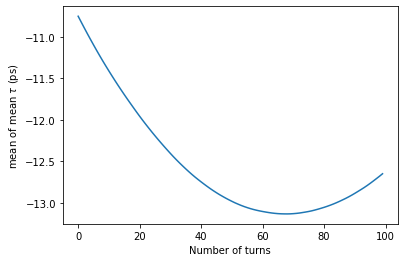

In [52]:
fig = plot_beamdata(filenames="tracking.hdf5", dataset="mean", dimension="tau", stat_var="mean") 

Plot the mean bunch length of all bunches:

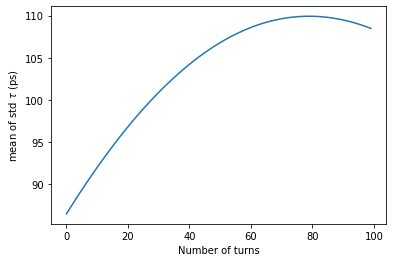

In [53]:
fig = plot_beamdata(filenames="tracking.hdf5", dataset="std", dimension="tau", stat_var="mean") 

Plot the bunch length versus bunch index:

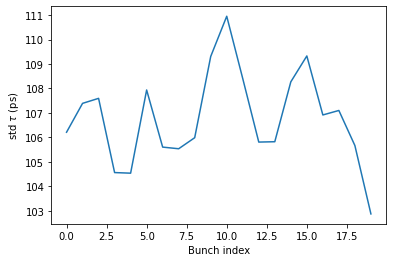

In [54]:
fig = plot_beamdata(filenames="tracking.hdf5", dataset="std", dimension="tau", x_var="index", turn=50) 

Plot the evolution of the longitudinal center of mass versus bunch index:

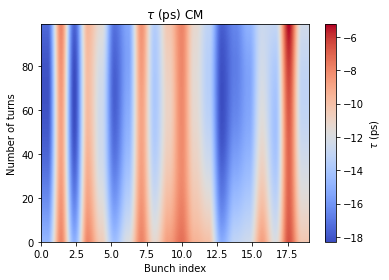

In [55]:
fig = streak_beamdata("tracking.hdf5", dataset="mean", dimension="tau")